In [1]:
%reload_ext autoreload
%autoreload 2

In [15]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import torch.optim as optim
import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display,clear_output

import warnings
warnings.filterwarnings("ignore")

In [16]:
from dataset import HelocDataset
from experiments import Benchmarking
from utils.logger_config import setup_logger
from tqdm import tqdm
from models.wrapper import PYTORCH_MODELS

logger = setup_logger()

In [17]:
from dataset import dataset_loader

In [18]:
name = 'heloc'
dataset_ares = dataset_loader(name, data_path='data/', dropped_features=[], n_bins=None)

In [19]:
from experiments.counterfactual import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from models import PyTorchDNN, PyTorchLinearSVM, PyTorchRBFNet, PyTorchLogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.gaussian_process import GaussianProcessClassifier

In [55]:
dataset = HelocDataset(dataset_ares=dataset_ares)

input_dim = dataset.get_dataframe().shape[1] - 1
seed = 102
torch.manual_seed(seed)

counterfactual_algorithms = [
    # 'DiCE',
    # 'DisCount',
    # 'GlobeCE'
    'AReS',
]

experiment = Benchmarking(
    dataset=dataset,
    models=[
        # (GaussianProcessClassifier(), 'sklearn'),
        # (PyTorchLogisticRegression(input_dim=input_dim), 'PYT'),
        # (PyTorchDNN(input_dim=input_dim), 'PYT'),
        (PyTorchRBFNet(input_dim=input_dim, hidden_dim=input_dim), 'PYT'),
        (PyTorchLinearSVM(input_dim=input_dim), 'PYT'),
        # (RandomForestClassifier(n_estimators=10), 'sklearn'), 
        # (GradientBoostingClassifier(n_estimators=10), 'sklearn'), 
        # (AdaBoostClassifier(n_estimators=10), 'sklearn'), 
    ],
    shapley_methods=[
        # "Train_Distri",
        "CF_UniformMatch",
        # "CF_SingleMatch",
        "CF_ExactMatch",
        "CF_SingleMatch",
        # "CF_OTMatch",
        "CF_OTMatch_0.5", 
        # "CF_OTMatch_1.0",
        # "CF_OTMatch_5.0",
        # "CF_OTMatch_10.0",
    ],
    distance_metrics=[
        'optimal_transport',
        'mean_difference',
        # 'median_difference',
        # 'max_mean_discrepancy',
    ]
)

experiment.train_and_evaluate_models(random_state=seed)
experiment.models_performance()

logger.info("\n\n------Compute Counterfactuals------")
sample_num = 300
model_counterfactuals = {}
for model, model_name in zip(experiment.models, experiment.model_names):
    model_counterfactuals[model_name] = {}

    for algorithm in counterfactual_algorithms:
        if algorithm == 'DisCount' and model_name not in PYTORCH_MODELS:
            logger.info(f'Skipping {algorithm} for {model_name} due to incompatability')
            continue
        logger.info(f'Computing {model_name} counterfactuals with {algorithm}')
        function_name = f"compute_{algorithm}_counterfactuals"
        try:
            func = globals()[function_name]
            model_counterfactuals[model_name][algorithm] = func(
                experiment.X_test,
                model = model,
                target_name = experiment.dataset.target_name,
                sample_num = sample_num,
                experiment=experiment,
            )
        except KeyError:
            print(f"Function {function_name} is not defined.")

INFO:root:PyTorchRBFNet accuracy: 0.7240506329113924
INFO:root:PyTorchLinearSVM accuracy: 0.7240506329113924
INFO:root:

------Compute Counterfactuals------
INFO:root:Computing PyTorchRBFNet counterfactuals with AReS


Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 6660 combinations | Sampling itemset size 6
SD and RL Computed with Lengths 2212 and 2212
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 2212 to 73


100%|██████████| 2212/2212 [00:01<00:00, 1387.71it/s]


Ground Set Computed with Length 80972


4999it [00:09, 505.38it/s]


Candidate Set Filtered with Length: 5000
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 9999.38it/s] 


Checking Exchange


100%|██████████| 4997/4997 [00:01<00:00, 3323.17it/s]


Checking Delete
Checking Add


100%|██████████| 4997/4997 [00:00<00:00, 9682.98it/s]
2it [00:00, 298.47it/s]
INFO:root:Computing PyTorchLinearSVM counterfactuals with AReS


Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 18888 combinations | Sampling itemset size 6
SD and RL Computed with Lengths 3894 and 3894
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 3894 to 346


100%|██████████| 3894/3894 [00:13<00:00, 290.01it/s] 


Ground Set Computed with Length 325762


4999it [00:07, 653.83it/s]


Candidate Set Filtered with Length: 5000
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 10166.83it/s]


Checking Exchange


100%|██████████| 4997/4997 [00:01<00:00, 3339.75it/s]


Checking Delete
Checking Add


100%|██████████| 4997/4997 [00:00<00:00, 9456.38it/s]
2it [00:00, 233.89it/s]


In [56]:
logger.info("\n\n------Compute Shapley Values------")
experiment.compute_shapley_values(
    model_counterfactuals=model_counterfactuals,
);

INFO:root:

------Compute Shapley Values------
INFO:root:Shapley values for PyTorchRBFNet using CF_UniformMatch with counterfactual by AReS


  0%|          | 0/73 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left = 0.7167414131850209
INFO:shap:np.sum(w_aug) = 23.000000000000007
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000004
INFO:shap:phi = array([ 0.06668488, -0.00404851,  0.01510479,  0.01505919,  0.01873596,
        0.01289327,  0.00463974,  0.02960511,  0.01358911,  0.01391914,
       -0.01386715,  0.00714947, -0.01886984,  0.02053985, -0.01055906,
       -0.01047604,  0.00697648,  0.07697581,  0.01016665,  0.00589745,
        0.00777846,  0.01977278,  0.01690059])
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left

  0%|          | 0/57 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left = 0.7167414131850209
INFO:shap:np.sum(w_aug) = 23.000000000000007
INFO:shap:np.sum(self.kernelWeights) = 1.0000000000000002
INFO:shap:phi = array([-0.06018517, -0.00098752, -0.00395987,  0.03312966, -0.03852291,
        0.00745239,  0.00057557, -0.00539589, -0.01445266, -0.03191078,
       -0.01150026,  0.00188652,  0.0093132 ,  0.0282244 , -0.0079712 ,
        0.06896314, -0.04623697,  0.01774217,  0.01913471, -0.01309793,
        0.00014241,  0.04433217,  0.00603798])
INFO:shap:num_full_subsets = 1
INFO:shap:remaining_weight_vector = array([0.20701126, 0.14490788, 0.11440096, 0.09660526, 0.08523993,
       0.07762922, 0.07245394, 0.06900375, 0.06688056, 0.06586722])
INFO:shap:num_paired_subset_sizes = 11
INFO:shap:weight_left

In [57]:
logger.info("\n\n------Evaluating Distance Performance Under Interventions------")
experiment.evaluate_distance_performance_under_interventions(
    intervention_num_list=[0, 50, 100, 150, 200, 300, 400, 600, 800],
    trials_num=100,
    replace=False
)

INFO:root:

------Evaluating Distance Performance Under Interventions------
INFO:root:Computing optimal_transport for (PyTorchRBFNet, AReS, CF_UniformMatch)
100%|██████████| 100/100 [00:01<00:00, 56.09it/s]
INFO:root:Computing mean_difference for (PyTorchRBFNet, AReS, CF_UniformMatch)
100%|██████████| 100/100 [00:00<00:00, 117.80it/s]
INFO:root:Computing optimal_transport for (PyTorchRBFNet, AReS, CF_ExactMatch)
100%|██████████| 100/100 [00:01<00:00, 52.22it/s]
INFO:root:Computing mean_difference for (PyTorchRBFNet, AReS, CF_ExactMatch)
100%|██████████| 100/100 [00:01<00:00, 93.24it/s]
INFO:root:Computing optimal_transport for (PyTorchRBFNet, AReS, CF_SingleMatch)
100%|██████████| 100/100 [00:01<00:00, 57.21it/s]
INFO:root:Computing mean_difference for (PyTorchRBFNet, AReS, CF_SingleMatch)
100%|██████████| 100/100 [00:00<00:00, 113.45it/s]
INFO:root:Computing optimal_transport for (PyTorchRBFNet, AReS, CF_OTMatch_0.5)
100%|██████████| 100/100 [00:01<00:00, 57.10it/s]
INFO:root:Computin

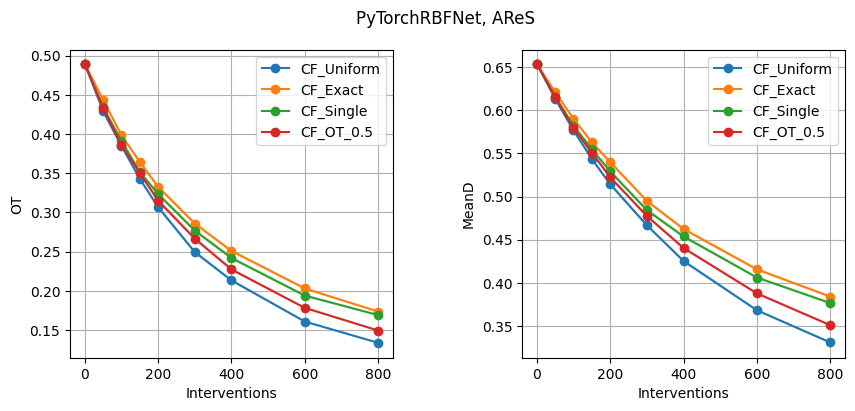

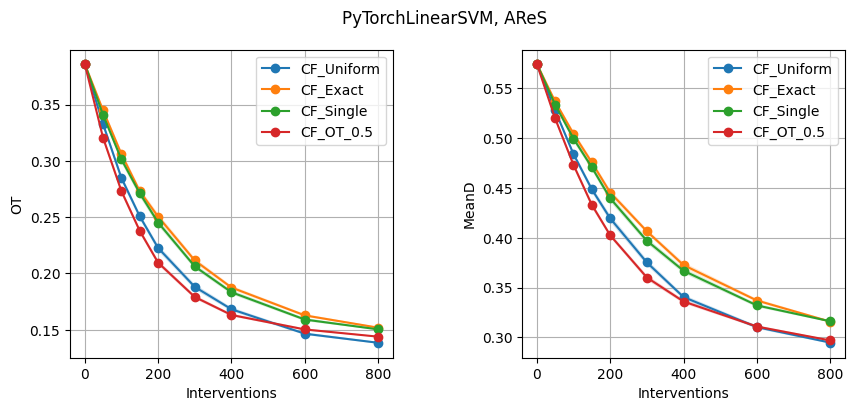

In [58]:
from experiments import plotting

plotting.intervention_vs_distance(experiment, save_to_file=False)

In [25]:
X_test = experiment.X_test
target_name = dataset.target_name
sample_num = 300

In [26]:
indices = get_factual_indices(X_test, model, target_name, sample_num)
df_factual = X_test.loc[indices]

ares = AReS(
    model=model,
    dataset=experiment.dataset.dataset_ares,
    X=df_factual,
    n_bins=10,
    normalise=None,
)  # 1MB
ares.generate_itemsets(
    apriori_threshold=0.2,
    max_width=None,  # defaults to e2-1
    affected_subgroup=None,
    save_copy=False,
)
# Note: progress bar initial time estimate about 10 times too large
ares.generate_groundset(
    max_width=None, RL_reduction=True, then_generation=None, save_copy=False
)
lams = [1, 0]  # can play around with these lambda values
ares.evaluate_groundset(
    lams=lams, r=5000, save_mode=1, disable_tqdm=False, plot_accuracy=False
)
ares.select_groundset(s=5000)
ares.optimise_groundset(lams=lams, factor=1, print_updates=False, print_terms=False)

df_counterfactual = pd.DataFrame(ares.R.cfx_matrix[0], columns=X_test.columns)


Computing Candidate Sets of Conjunctions of Predicates SD and RL
Processing 8874 combinations | Sampling itemset size 65
SD and RL Computed with Lengths 2639 and 2639
Computing Ground Set of Triples V
Reducing RL
RL Reduced from Size 2639 to 102


100%|██████████| 2639/2639 [00:02<00:00, 985.83it/s] 


Ground Set Computed with Length 121888


4999it [00:08, 615.54it/s]


Candidate Set Filtered with Length: 5000
Initialising Copy of Ground Set
While there exists a delete/update operation, loop:
Checking Delete
Checking Add


100%|██████████| 4999/4999 [00:00<00:00, 9327.81it/s] 


Checking Exchange


100%|██████████| 4993/4993 [00:04<00:00, 1132.49it/s]


Checking Delete
Checking Add


100%|██████████| 4993/4993 [00:00<00:00, 8031.34it/s]
6it [00:00, 517.12it/s]


In [27]:
X_counterfactual = df_counterfactual.values
y_counterfactual = model.predict(X_counterfactual)

final_sample_num = min(df_factual.shape[0], df_counterfactual.shape[0])

X_factual = df_factual.sample(final_sample_num).values
y_factual = model.predict_proba(X_factual)

In [28]:
N = X_factual.shape[0]

In [31]:
import ot
ot_cost = ot.dist(X_factual, X_counterfactual)
ot_plan = ot.emd(np.ones(N) / N, np.ones(N) / N, ot_cost)

In [70]:
probs = np.diag(np.ones(N)) / N

In [73]:
probs

array([[0.02272727, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02272727, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02272727, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.02272727, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02272727,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02272727]])

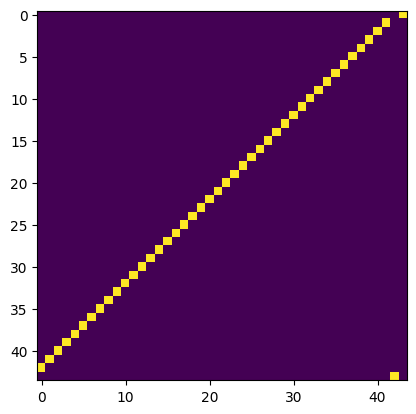

In [81]:
plt.imshow(ot_plan)

In [ ]:
ares.